# Project - Kriging the French temperatures

## Some useful reading before we start

**Theoretical resources**
- [Bachelor thesis on Kriging methods](https://mediatum.ub.tum.de/1173364)
- [Summer school tutorial on Kriging methods](https://hal.archives-ouvertes.fr/cel-01081304)
- [Gaussian Process, not quite for dummies](https://yugeten.github.io/posts/2019/09/GP/)

**Technical resources**
- [Plotting map with cartopy](https://scitools.org.uk/cartopy/docs/v0.13/matplotlib/advanced_plotting.html)
- [_Points in polygon_ technique](https://automating-gis-processes.github.io/2016/Lesson3-point-in-polygon.html)
- [Draw a map with Python [FR]](http://www.xavierdupre.fr/app/papierstat/helpsphinx/notebooks/enedis_cartes.html)
- [Plotting an static image over an interactive map (optional)](https://ocefpaf.github.io/python4oceanographers/blog/2015/07/13/interactive_geo/)

## Intoduction

**What we have:** the synchronized measurement of temperature $t$, from stations spread around Metropolitan France.

**What we want:** a map of the temperature covering all the French Mainland, by **simple kriging** interpolation.

The roadmap of the things to do is:
1. Get the necessary data & preprocess:
    1. Download information about station & plot on a map
    2. Download temperature data, choose a month/year & plot a time serie
2. Kriging, first step: fitting & choosing a model
    1. Choose an hour/day
    1. Create the variogram
    2. Estimate the modeled covariance
3. Kriging, second step: compute the simple Kriging
    1. Krige the mean temperature & compute its variance
    2. Create a rectangular set of coordinates which covers the MainLand
    3. Compute Simple kriging on the zero-mean part of the signal & compute its variance
5. Plot the kriged map

## 1. Get the necessary data & preprocess
### A. Download informations about stations & plot on map

MeteoFrance partially provides open data from the *SYNOP* network:
- link for station infos in GeoJSON [here](https://donneespubliques.meteofrance.fr/donnees_libres/Txt/Synop/postesSynop.json)
- link for station infos in csv [here](https://donneespubliques.meteofrance.fr/donnees_libres/Txt/Synop/postesSynop.csv)

First let's download this file. I go for the csv format. For the preprocessing, I keep stations on MainLand only, because kriging needs sensing nodes to be nearby.

In [1]:
import os
import requests
import pandas

fname_stations = "file_stations.csv"
url_stations = "https://donneespubliques.meteofrance.fr/donnees_libres/Txt/Synop/postesSynop.csv"

if os.path.exists(fname_stations) is False:
    with open(fname_stations, "wb") as fid:
        file_stations = requests.get(url_stations)
        fid.write(file_stations.content)

fpd_st = pandas.read_csv("file_stations.csv", delimiter=";")
fpd_st = fpd_st[0:40]  # Mainland only

print("How the station file looks like")
fpd_st

How the station file looks like


,ID,Nom,Latitude,Longitude,Altitude
0,7005,ABBEVILLE,50.136000,1.834000,69
1,7015,LILLE-LESQUIN,50.570000,3.097500,47
2,7020,PTE DE LA HAGUE,49.725167,-1.939833,6
3,7027,CAEN-CARPIQUET,49.180000,-0.456167,67
4,7037,ROUEN-BOOS,49.383000,1.181667,151
5,7072,REIMS-PRUNAY,49.209667,4.155333,95
6,7110,BREST-GUIPAVAS,48.444167,-4.412000,94
7,7117,PLOUMANAC'H,48.825833,-3.473167,55
8,7130,RENNES-ST JACQUES,48.068833,-1.734000,36
9,7139,ALENCON,48.445500,0.110167,143


Let's visualize stations on a map with folium. We also prepare the rectangular bound in which the map will be computed later.

In [3]:
import folium

mapf = folium.Map(location=(47, 2), zoom_start=5)
for _, station in fpd_st.iterrows():
    marker = folium.Marker(location=(station.Latitude, station.Longitude),
                                     weight=1, color="Green",
                                     tooltip=f"{station.Nom.title()} | {station.ID}")
    marker.add_to(mapf)

bound_map = ((42.3, -5), (51.1, 8.3))
rect = folium.Rectangle(bound_map, color="Gray",
                        tooltip="Bounds for the temperature map to come")
rect.add_to(mapf)

mapf

### B. Download temperature data, choose a month/year & plot a time serie

For the download:
- we use the archive link of a température file. With MM the month and AAAA the year, the url is
https://donneespubliques.meteofrance.fr/donnees_libres/Txt/Synop/Archive/synop.AAAAMM.csv.gz
- I manage to find a year/month/day/hour in which there is no Nan

In [4]:
import gzip

year, month = "2020", "01"

url_temp = "https://donneespubliques.meteofrance.fr/donnees_libres/Txt/Synop/Archive/synop.{}{}.csv.gz".format(year, month)
fname_temp_end = url_temp.split("/")[-1].replace("csv.gz", "csv")  # calling gzip is not necessary (why...)
fname_temp = "file_{}".format(fname_temp_end)

if os.path.exists(fname_temp) is False:
    zipped_content = requests.get(url_temp).content
    with open(fname_temp, "wb") as fid:
            fid.write(gzip.decompress(zipped_content))


fpd_tp = pandas.read_csv(fname_temp, delimiter=";")

# Preprocessing: drop useless data, cast to numeric datatypes
fpd_tp = fpd_tp[["numer_sta", "date", "t"]]  # keep useful columns
fpd_tp = fpd_tp[fpd_tp["numer_sta"].isin(fpd_st.ID)]  # keep metropolitan stations
fpd_tp = fpd_tp.replace({"mq": "nan"})  # replace mq by nan
fpd_tp = fpd_tp.astype({"t": float})  # convert temperatures to float

print("Datatypes of the dataframe")
print(fpd_tp.dtypes, sep="")
print("How the dataframe looks like")

fpd_tp

Datatypes of the dataframe
numer_sta      int64
date           int64
t            float64
dtype: object
How the dataframe looks like


,numer_sta,date,t
0,7005,20200101000000,274.35
1,7015,20200101000000,275.25
2,7020,20200101000000,280.55
3,7027,20200101000000,275.75
4,7037,20200101000000,272.25
...,...,...,...
14809,7643,20200131210000,285.95
14810,7650,20200131210000,282.75
14811,7661,20200131210000,283.65
14812,7690,20200131210000,286.65


For vizualization, I take the time serie from Toulouse. Note that the measured temperature is in Kelvin.

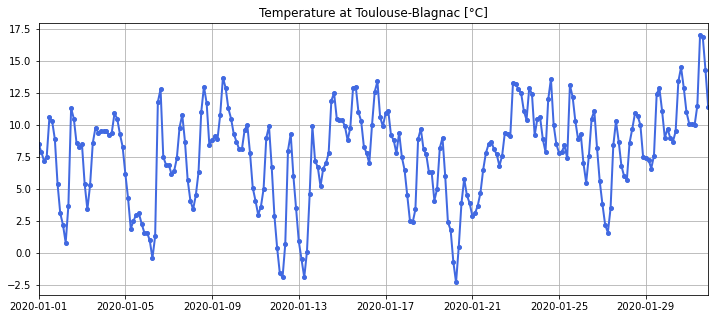

In [5]:
import matplotlib.pyplot as plt
import numpy as np

const_k2c = 273.15  # to convert Kelvin to Celsius
name_tls = "TOULOUSE-BLAGNAC"
id_tls = int(fpd_st.ID[fpd_st.Nom == name_tls])
fpd_tls = fpd_tp[fpd_tp.numer_sta == id_tls]  # data toulouse
time_formatted = pandas.to_datetime(fpd_tls.date, format="%Y%m%d%H%M%S")

plt.figure(figsize=(12, 5))
plt.plot(time_formatted, fpd_tls.t - const_k2c, "-o",
         color="RoyalBlue", linewidth=2, markersize=4)
plt.title(f"Temperature at {name_tls.title()} [°C]")
plt.margins(x=0)
plt.grid()

## 2. Kriging, first step: fitting & choosing a model

From that point, if you want to understand how to do simple Kriging, you should definitely read the Chapter 6 of [Andreas Lichtenstern's Bachelor thesis](https://mediatum.ub.tum.de/doc/1173364/1173364.pdf).

### A. Choose an hour/day
We will focus on the synchronized measurements at the following time. Watch out, there are data every 3 hours only (00am, 3am, 6am, etc.)

In [6]:
year, month, day, hour = year, month, "01", "03" # 2020-01-01 @03:00 am

date = int("".join((year, month, day, hour, "00", "00"))) #AAAAMMDDHHMMSS  
print(date)
temp = fpd_tp[fpd_tp.date == date]
print("number of Nans at chosen date:", np.sum(np.isnan(temp.t.values)))

20200101030000
number of Nans at chosen date: 0


### B. Create a variogram
To create the variogram we need:
- the paiwise distances between stations $d_{ij} = \| \mathbf{x}_i - \mathbf{x}_j \|$, based on (latitude, longitude) coordinates. For accuracy, we compute the distances of arcs on the sphere rather than Euclidean distances.
- raw values of the variogram $\dfrac{\left(t(\mathbf{x}_i) - t(\mathbf{x}_j)\right)^2}{2}$, as a fonction of $d_{ij}$
- the binned means of the variogram


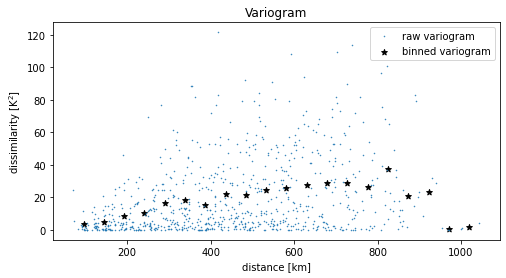

In [7]:
import numpy as np
from scipy.spatial.distance import squareform
from scipy.stats import binned_statistic
import pymap3d

# Compute the pairwise distances
lats_st = fpd_st.Latitude.to_numpy()
lons_st = fpd_st.Longitude.to_numpy()
pdist = np.zeros((lats_st.size, lats_st.size))
for i in range(lats_st.size):
    for j in range(i):
        pdist[i, j] = pymap3d.vincenty.vdist(lats_st[i], lons_st[i], lats_st[j], lons_st[j])[0]
        pdist[j, i] = pdist[i, j]
        
# Compute the raw variogram values
dissim = np.abs(temp["t"].values[:, None] - temp["t"].values[None, :])**2 / 2
dissim_ = squareform(dissim)
pdist_ = squareform(pdist)

# Create a binned variogram
variogram, edges, _ = binned_statistic(pdist_, dissim_,
                                       statistic='mean', bins=20)
dist_binned = edges[:-1] + (edges[1] - edges[0])/2
plt.figure(figsize=(8, 4))
plt.title("Variogram")
plt.plot(squareform(pdist)/1e3, squareform(dissim), ".", markersize=1, label="raw variogram")
plt.xlabel("distance [km]")
plt.ylabel(r"dissimilarity [K$^2$]")    
plt.scatter(dist_binned/1e3, variogram,
            marker="*", color="black", label="binned variogram")
plt.xlabel("distance [km]")
plt.ylabel(r"dissimilarity [K$^2$]")
plt.legend()

### C. Estimate the modeled covariance 

Finally, fit the binned variogram to the gaussian covariance model. If the gaussian covariance $C_{ij}$ is such that

$$C_{ij} = b e^{- \frac{d_{ij}^2}{2 a^2}} \text{ ,}$$

then the variogram $\gamma_{ij}$ has the analytical form: 

$$\gamma_{ij} = b \left(1 - e^{- \frac{d_{ij}^2}{2 a^2}} \right)$$

*Tips*: note that there are outliers, so:
- use a robust loss function (e.g. $\ell_1$ or huber, rather than $\ell_2$ least-square)
- weight the cost function by the number of samples per bin

Fitted parameters with linear metric:	 a=258269.433304702 	 b=28.2710305114871
Fitted parameters with huber metric:	 a=234637.337515012 	 b=27.000911357401638
Fitted parameters with soft_l1 metric:	 a=234654.89510158176 	 b=27.00187003580491


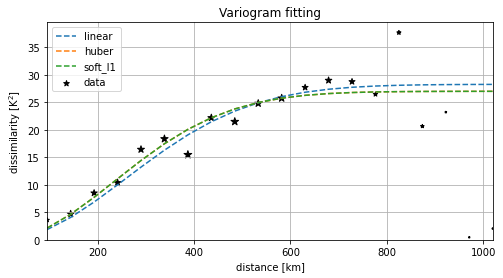

In [8]:
from scipy import optimize

def covariance_gaussian(h, a, b):
    return b*np.exp(-h**2 / (2*a**2))

def variogram_gaussian(h, a, b):
    return b*(1 - np.exp(-h**2 / (2*a**2)))

def residual_variogram_gaussian(arr, variogram_data, variogram_dist,
                                weight_res=None):
    a, b = arr
    res =  variogram_gaussian(variogram_dist, a, b) - variogram_data
    if weight_res is None:
        return res
    else:
        return weight_res * res

# For fitting, I weight the data by the number of points in each bin:
weight_res = np.histogram(squareform(pdist), bins=edges)[0].astype(float)
# ...or not:
#weight_res = None

# Fitting here
res_fit = {}
metrics = ["linear", "huber", "soft_l1"]
for metric_ in metrics:  # linear, soft_l1, huber, cauchy, arctan
    res = optimize.least_squares(residual_variogram_gaussian, [300e3, 60],
                                 bounds=([0., 0.], [np.inf, np.inf]),
                                 loss=metric_,
                                 args=[variogram, dist_binned, weight_res])
    res_fit[metric_] = res

plt.figure(figsize=(8, 4))
plt.title("Variogram fitting")
plt.scatter(dist_binned/1e3, variogram,
            s=weight_res,
            marker="*", color="black", label="data")
for metric_, res_ in res_fit.items():
    plt.plot(dist_binned/1e3, variogram_gaussian(dist_binned, *res_.x), "--", label=metric_)
plt.grid()
plt.ylim(ymin=0)
plt.margins(x=1e-3)
plt.xlabel("distance [km]")
plt.ylabel(r"dissimilarity [K$^2$]")
plt.legend()

for metric_, res_ in res_fit.items():
    print(f"Fitted parameters with {metric_} metric:\t a={res_.x[0]} \t b={res_.x[1]}", )

Now we have $a$ and $b$ from fitting (by soft_l1), we can build the _learned_ covariance matrix.

covariance condition number is 1248280.667782543


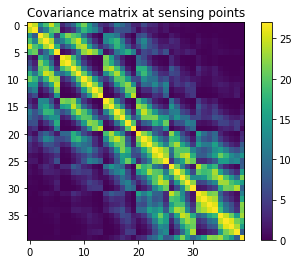

In [9]:
a_learned, b_learned = res_fit["soft_l1"].x
cov_learned = b_learned * np.exp(-pdist**2 / (2*a_learned**2))

# Check the condition number before using cov_learned, as it will be
# inversed the covariance matrix
print("covariance condition number is", np.linalg.cond(cov_learned))
cov_learned_inv = np.linalg.pinv(cov_learned)  # 

plt.figure()
plt.title("Covariance matrix at sensing points")
plt.imshow(cov_learned, vmin=0)
plt.colorbar()

## 3. Kriging, second step: compute the simple Kriging
### A. Krige the mean temperature & compute its variance

Krige the mean, compute the variance, and compare with vanilla mean & variance

In [10]:
ones_ = np.ones(temp.shape[0])
weights_mean = cov_learned_inv @ ones_ / cov_learned_inv.sum()

mean_krig = temp.t.values @ weights_mean
var_mean_krig = 1 / cov_learned_inv.sum()

print("Temperature \t Mean [°C] \t\t Variance [°C²]")
print("Kriged  \t", mean_krig - const_k2c, " \t {}".format(var_mean_krig))
print("Vanilla \t", temp.t.mean() - const_k2c, "\t {}".format(temp.t.var()))

Temperature 	 Mean [°C] 		 Variance [°C²]
Kriged  	 10.822046005665129  	 4.538199992829337
Vanilla 	 3.2349999999999 	 19.381820512820493


### B. Create a rectangular set of coordinates which covers the MainLand

1. We create a set of interpolation points covering the Mainland (using the bounds defined in part 1.A.)
2. Then we ompute the pairwise distances between interpolation and sensing points. For accuracy, we compute the distances of arcs on the sphere rather than Euclidean distances.

In [11]:
from tqdm import tqdm

# Create points for interpolation
n_width = 100  # Takes time if n_width > 50...
lat_map_uni = np.linspace(bound_map[0][0], bound_map[1][0], n_width)
lon_map_uni = np.linspace(bound_map[0][1], bound_map[1][1], n_width)
lat_map, lon_map = np.meshgrid(lat_map_uni, lon_map_uni)
lat_map_ = lat_map.ravel()
lon_map_ = lon_map.ravel()

# Create the matrix of parwise distances between latitudes. It takes some time...
rdist = np.zeros((lats_st.size, lat_map_.size))
for i in tqdm(range(lats_st.size)):
    for j in range(lat_map_.size):
        rdist[i, j] = pymap3d.vincenty.vdist(lats_st[i], lons_st[i], lat_map_[j], lon_map_[j])[0]

100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:47<00:00,  1.20s/it]


### C. Compute Simple kriging on the zero-mean part of the signal & compute its variance
Here we **do the simple kriging** (finally !), and interpolate the part of the signal fluctuating around the mean.

In [12]:
# Compute the gaussian covariance model
cov_krig_meas = covariance_gaussian(rdist, a_learned, b_learned)

# Do interpolation by simple kriging
weights_sk = cov_learned_inv @ cov_krig_meas
temp_sk = mean_krig + (temp.t.values - mean_krig) @ weights_sk
var_sk = cov_learned[0, 0] - (cov_krig_meas * weights_sk).sum(axis=0)  # hypothesis : cov_learned diagonal elements are equal.

## 4. Plot the kriged map

Since folium does not natively handles map vizualisation, I switch to cartopy. I vizualize both kriging and variance, and use either pcolor or contourf for the aspect.

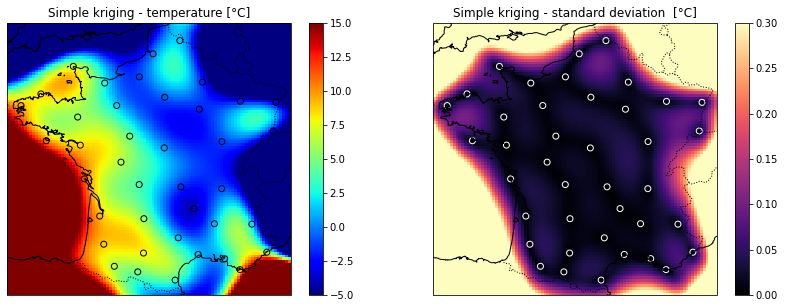

In [13]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

map_temp_sk = temp_sk.reshape((n_width, n_width))
map_var_sk = var_sk.reshape((n_width, n_width))

map_type = "pcolor"  # map style of kriging (expectation)
fig = plt.figure(figsize=(14, 5))

# Kriging - Excpectation
temp_sk_min = 5*np.floor((temp.t.min() - const_k2c)/5)
temp_sk_max = 5*np.ceil((temp.t.max() - const_k2c)/5)
ax = fig.add_subplot(121, projection=ccrs.PlateCarree())
if map_type == "pcolor":
    im = ax.pcolormesh(lon_map_uni, lat_map_uni, (map_temp_sk - const_k2c).T,
                      vmin=temp_sk_min, vmax=temp_sk_max, cmap="jet")
elif map_type == "contourf":
    levels = np.arange(temp_sk_min, temp_sk_max+1e-6, 1)
    im = ax.contourf(lon_map_uni, lat_map_uni, (map_temp_sk - const_k2c).T,
                     levels=levels,
                     extend="min",
                     cmap="jet")
ax.scatter(lons_st, lats_st, c=temp.t.values - const_k2c,
           cmap='jet', edgecolor="black",
           vmin=im.get_clim()[0], vmax=im.get_clim()[1])
plt.colorbar(im)
ax.margins(0)
ax.add_feature(cfeature.BORDERS.with_scale('50m'), linestyle=':')
ax.coastlines()
ax.set_title("Simple kriging - temperature [°C]")
ax.set_aspect("auto")

# Kriging - Variance
ax = fig.add_subplot(122, projection=ccrs.PlateCarree())
im = ax.pcolormesh(lon_map_uni, lat_map_uni, (map_var_sk**0.5).T,
                  vmin=0, vmax=0.3, cmap="magma")
ax.scatter(lons_st, lats_st, edgecolor="white", facecolor="none")
plt.colorbar(im)
ax.margins(0)
ax.add_feature(cfeature.BORDERS.with_scale('50m'), linestyle=':')
ax.coastlines()
ax.set_title("Simple kriging - standard deviation  [°C]")
ax.set_aspect("auto")

### Mask the values so that the map convers the French MainLand only

The temperature map provides inconsistent values beyond the Mainland. The idea here is to _crop_ the map and draw only the values of interest.

From the polygons created by [Grégoire David](https://github.com/gregoiredavid/france-geojson), I subsampled the French Mainland one and saved it into `file_polygon_mainland_France.npy`. Based on the intersection of this polygon and the set of interpolated points, we can finally crop the previous map and plot only the useful part. To do so, the "point in polygon" algorithm helps to find the interpolation points which are inside the polygon.

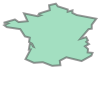

In [14]:
from shapely.geometry import Point, Polygon

lonlat_poly = np.load("file_polygon_mainland_France.npy")
poly = Polygon(lonlat_poly.T)  # create a Polygon

# create Point objects
point_collection = [Point(lon_, lat_)
                    for (lon_, lat_) in zip(lon_map_, lat_map_)]

# create the mask with the point-in-polygon algorithm
mask = np.array([p.within(poly) for p in point_collection])
poly  # visualize the polygon

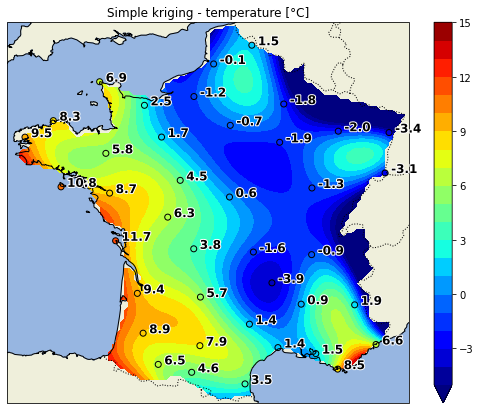

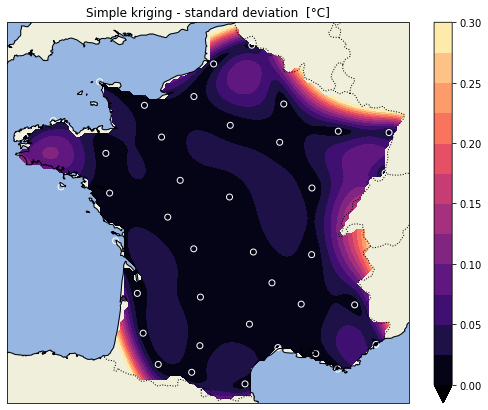

In [15]:
import cartopy.crs as ccrs
import matplotlib.patheffects as pe

# Mask the points outside the polygon
temp_sk_masked = temp_sk.copy()
temp_sk_masked[~mask] = np.nan
map_temp_sk_masked = temp_sk_masked.reshape((n_width, n_width))
var_sk_masked = var_sk.copy()
var_sk_masked[~mask] = np.nan
map_var_sk_masked = var_sk_masked.reshape((n_width, n_width))

map_type = "contourf"  # map style of kriging (expectation)

# Kriging - Excpectation
fig = plt.figure(figsize=(9, 7))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
if map_type == "pcolor":
    im = ax.pcolormesh(lon_map_uni, lat_map_uni, (map_temp_sk_masked - const_k2c).T,
                       vmin=temp_sk_min, vmax=temp_sk_max, cmap="jet")
elif map_type == "contourf":
    levels = np.arange(temp_sk_min, temp_sk_max+1e-6, 1)
    im = ax.contourf(lon_map_uni, lat_map_uni, (map_temp_sk_masked - const_k2c).T,
                     levels=levels,
                     extend="min",
                     cmap="jet")
ax.scatter(lons_st, lats_st, c=temp.t.values - const_k2c,
           cmap='jet', edgecolor="black",
           vmin=im.get_clim()[0], vmax=im.get_clim()[1])
plt.colorbar(im)
ax.margins(0.1)
ax.add_feature(cfeature.BORDERS.with_scale('50m'), linestyle=':')
ax.coastlines()
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.set_title("Simple kriging - temperature [°C]")
ax.set_aspect("auto")
# print true values
for _, station in fpd_st.iterrows():
    plt.text(station.Longitude+0.2, station.Latitude,
             str(round(float(temp[temp.numer_sta==station.ID].t -
                             const_k2c), 2)),
             fontsize=12, weight="bold", color="black",
             path_effects=[pe.withStroke(linewidth=2, foreground="white")])

# Kriging - Variance
fig = plt.figure(figsize=(9, 7))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
if map_type == "pcolor":
    im = ax.pcolormesh(lon_map_uni, lat_map_uni, (map_temp_sk_masked - const_k2c).T,
                       vmin=0, vmax=0.3, cmap="magma")
elif map_type == "contourf":
    levels = np.arange(0, 0.3+1e-6, 0.025)
    im = ax.contourf(lon_map_uni, lat_map_uni, (map_var_sk_masked**0.5).T,
                     levels=levels,
                     extend="min",
                     cmap="magma")

ax.scatter(lons_st, lats_st, edgecolor="white", facecolor="none")
plt.colorbar(im)
ax.margins(0.1)
ax.add_feature(cfeature.BORDERS.with_scale('50m'), linestyle=':')
ax.coastlines()
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.set_title("Simple kriging - standard deviation  [°C]")
ax.set_aspect("auto")